In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
target_train_path = '/content/drive/MyDrive/target_train.csv'
medclms_train_path = '/content/drive/MyDrive/medclms_train.csv'
rxclms_train_path = '/content/drive/MyDrive/rxclms_train.csv'
# Load the training datasets
target_train = pd.read_csv(target_train_path , parse_dates=['therapy_start_date', 'therapy_end_date'])
medclms_train = pd.read_csv(medclms_train_path, parse_dates=['visit_date'])
rxclms_train = pd.read_csv(rxclms_train_path, parse_dates=['service_date'])

In [27]:
# Preprocess target_train.csv
target_train = pd.get_dummies(target_train, columns=['sex_cd'], drop_first=True)
target_train['therapy_start_date'] = pd.to_datetime(target_train['therapy_start_date']).dt.tz_localize(None)
target_train['therapy_end_date'] = pd.to_datetime(target_train['therapy_end_date']).dt.tz_localize(None)
target_train['therapy_duration'] = (target_train['therapy_end_date'] - target_train['therapy_start_date']).dt.days

# Preprocess medclms_train.csv
medclms_train.drop(columns=['reversal_ind', 'clm_type'], inplace=True)
medclms_train = pd.get_dummies(medclms_train, columns=['pot', 'util_cat', 'hedis_pot'], drop_first=True)
medclms_train['visit_day_of_week'] = medclms_train['visit_date'].dt.dayofweek
medclms_train['visit_month'] = medclms_train['visit_date'].dt.month

# Preprocess rxclms_train.csv
rxclms_train.drop(columns=['reversal_ind', 'clm_type', 'document_key'], inplace=True)
rxclms_train = pd.get_dummies(rxclms_train, columns=['gpi_drug_group_desc', 'gpi_drug_class_desc', 'hum_drug_class_desc'], drop_first=True)
rxclms_train['service_day_of_week'] = rxclms_train['service_date'].dt.dayofweek
rxclms_train['service_month'] = rxclms_train['service_date'].dt.month

# Aggregated features for medclms_train.csv
medclms_count = medclms_train.groupby('therapy_id').size().reset_index(name='medclms_count')
medclms_diagnosis_sum = medclms_train.groupby('therapy_id')[['ade_diagnosis', 'pain_diagnosis', 'diarrhea_diagnosis','constipation_diagnosis','nausea_diagnosis','hyperglycemia_diagnosis','seizure_diagnosis']].sum().reset_index()
medclms_aggregated = pd.merge(medclms_count, medclms_diagnosis_sum, on='therapy_id')

# Aggregated features for rxclms_train.csv
rxclms_count = rxclms_train.groupby('therapy_id').size().reset_index(name='rxclms_count')
rxclms_avg_cost = rxclms_train.groupby('therapy_id')['rx_cost'].sum().reset_index(name='avg_rx_cost')
rxclms_treatment_sum = rxclms_train.groupby('therapy_id')[['ddi_ind','anticoag_ind', 'diarrhea_treat_ind', 'seizure_treat_ind', 'diarrhea_treat_ind', 'nausea_treat_ind']].sum().reset_index()
rxclms_aggregated = pd.merge(rxclms_count, rxclms_avg_cost, on='therapy_id')
rxclms_aggregated = pd.merge(rxclms_aggregated, rxclms_treatment_sum, on='therapy_id')

# Merge the datasets
consolidated_data = pd.merge(target_train, medclms_aggregated, on='therapy_id', how='left')
consolidated_data = pd.merge(consolidated_data, rxclms_aggregated, on='therapy_id', how='left')
consolidated_data.fillna(0, inplace=True)


In [ ]:
# Specify the output file path with the filename
output_filepath = '/content/drive/MyDrive/consolidated_data.csv'

# Save the merged data to a CSV file
consolidated_data.to_csv(output_filepath, index=False)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
# Split data into training and validation sets
X = consolidated_data.drop(columns=['id','therapy_start_date', 'therapy_end_date', 'therapy_id', 'tgt_ade_dc_ind'])
y = target_train['tgt_ade_dc_ind']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_val_pred = rf_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_val_pred)


In [29]:
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


# Print the AUC score
print("AUC Score:", auc_score)

Accuracy: 0.9473684210526315
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       221
           1       0.81      0.65      0.72        26

    accuracy                           0.95       247
   macro avg       0.88      0.82      0.85       247
weighted avg       0.94      0.95      0.94       247

Confusion Matrix:
 [[217   4]
 [  9  17]]
AUC Score: 0.8178733031674208


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Your data preparation code here...

# Split data into training and validation sets
# Assuming consolidated_data and target_train are defined
X = consolidated_data.drop(columns=['id','therapy_start_date', 'therapy_end_date', 'therapy_id', 'tgt_ade_dc_ind'])
y = target_train['tgt_ade_dc_ind']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = gb_classifier.predict(X_val)
y_val_proba = gb_classifier.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_gb = accuracy_score(y_val, y_val_pred)
auc_gb = roc_auc_score(y_val, y_val_pred)  # Correct method
conf_matrix_gb = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

# Print the results
print("Accuracy:", accuracy_gb)
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix_gb)
print("AUC Score:", auc_gb)


Accuracy: 0.951417004048583
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       221
           1       0.77      0.77      0.77        26

    accuracy                           0.95       247
   macro avg       0.87      0.87      0.87       247
weighted avg       0.95      0.95      0.95       247

Confusion Matrix:
 [[215   6]
 [  6  20]]
AUC Score: 0.8710407239819005


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1115
           1       0.99      0.92      0.96       117

    accuracy                           0.99      1232
   macro avg       0.99      0.96      0.98      1232
weighted avg       0.99      0.99      0.99      1232

Combined AUC Score (Positive Class): 0.9987275305660955
Combined AUC Score (Negative Class): 0.0012724694339044107
Confusion Matrix:
 [[1114    1]
 [   9  108]]


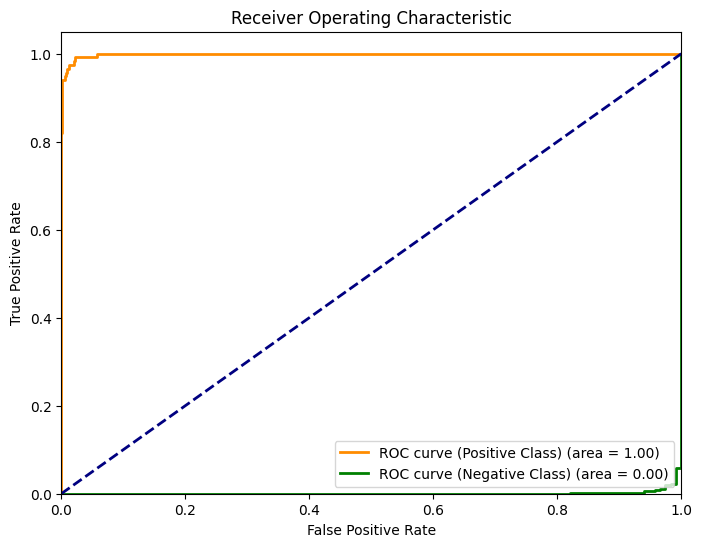

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Your data preparation code here...

# Assuming consolidated_data and target_train are defined
X = consolidated_data.drop(columns=['id','therapy_start_date', 'therapy_end_date', 'therapy_id', 'tgt_ade_dc_ind'])
y = target_train['tgt_ade_dc_ind']

# Train the Gradient Boosting model on the entire dataset
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X, y)

# Predict probabilities for both classes
y_proba = gb_classifier.predict_proba(X)

# Generate a classification report
class_report = classification_report(y, gb_classifier.predict(X))

# Compute the ROC curve for both classes
fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
fpr_neg, tpr_neg, _ = roc_curve(1 - y, 1 - y_proba[:, 0])

# Calculate the combined AUC for both classes
roc_auc = auc(fpr, tpr)
roc_auc_neg = auc(fpr_neg, tpr_neg)

# Generate a confusion matrix
conf_matrix_gb = confusion_matrix(y, gb_classifier.predict(X))

# Print the classification report, combined AUC, and confusion matrix
print("Classification Report:\n", class_report)
print("Combined AUC Score (Positive Class):", roc_auc)
print("Combined AUC Score (Negative Class):", roc_auc_neg)
print("Confusion Matrix:\n", conf_matrix_gb)

# Plot the ROC curve (optional)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Positive Class) (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve (Negative Class) (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Validation

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
target_train_path = '/content/drive/MyDrive/target_holdout.csv'
medclms_train_path = '/content/drive/MyDrive/medclms_holdout.csv'
rxclms_train_path = '/content/drive/MyDrive/rxclms_holdout.csv'

# Load the holdout datasets
target_holdout = pd.read_csv(target_train_path, parse_dates=['therapy_start_date'])
medclms_holdout = pd.read_csv(medclms_train_path, parse_dates=['visit_date'])
rxclms_holdout = pd.read_csv(rxclms_train_path, parse_dates=['service_date'])


In [ ]:
# Preprocess target_holdout.csv
target_holdout = pd.get_dummies(target_holdout, columns=['sex_cd'], drop_first=True)

# Preprocess medclms_holdout.csv
medclms_holdout.drop(columns=['reversal_ind', 'clm_type'], inplace=True)
medclms_holdout = pd.get_dummies(medclms_holdout, columns=['pot', 'util_cat', 'hedis_pot'], drop_first=True)
medclms_holdout['visit_day_of_week'] = medclms_holdout['visit_date'].dt.dayofweek
medclms_holdout['visit_month'] = medclms_holdout['visit_date'].dt.month

# Preprocess rxclms_holdout.csv
rxclms_holdout.drop(columns=['reversal_ind', 'clm_type', 'document_key'], inplace=True)
rxclms_holdout = pd.get_dummies(rxclms_holdout, columns=['gpi_drug_group_desc', 'gpi_drug_class_desc', 'hum_drug_class_desc'], drop_first=True)
rxclms_holdout['service_day_of_week'] = rxclms_holdout['service_date'].dt.dayofweek
rxclms_holdout['service_month'] = rxclms_holdout['service_date'].dt.month

# Aggregated features for medclms_holdout.csv
medclms_count_holdout = medclms_holdout.groupby('therapy_id').size().reset_index(name='medclms_count')
medclms_diagnosis_sum_holdout = medclms_holdout.groupby('therapy_id')[['ade_diagnosis', 'pain_diagnosis', 'diarrhea_diagnosis','constipation_diagnosis','nausea_diagnosis','hyperglycemia_diagnosis','seizure_diagnosis']].sum().reset_index()
medclms_aggregated_holdout = pd.merge(medclms_count_holdout, medclms_diagnosis_sum_holdout, on='therapy_id')

# Aggregated features for rxclms_holdout.csv
rxclms_count_holdout = rxclms_holdout.groupby('therapy_id').size().reset_index(name='rxclms_count')
rxclms_avg_cost_holdout = rxclms_holdout.groupby('therapy_id')['rx_cost'].mean().reset_index(name='avg_rx_cost')
rxclms_treatment_sum_holdout = rxclms_holdout.groupby('therapy_id')[['ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind', 'seizure_treat_ind', 'diarrhea_treat_ind', 'nausea_treat_ind']].sum().reset_index()
rxclms_aggregated_holdout = pd.merge(rxclms_count_holdout, rxclms_avg_cost_holdout, on='therapy_id')
rxclms_aggregated_holdout = pd.merge(rxclms_aggregated_holdout, rxclms_treatment_sum_holdout, on='therapy_id')

# Merge the datasets
consolidated_data_holdout = pd.merge(target_holdout, medclms_aggregated_holdout, on='therapy_id', how='left')
consolidated_data_holdout = pd.merge(consolidated_data_holdout, rxclms_aggregated_holdout, on='therapy_id', how='left')
consolidated_data_holdout.fillna(0, inplace=True)


In [ ]:
# Align columns of holdout data with training data
common_columns = set(consolidated_data.columns) & set(consolidated_data_holdout.columns)

# Filter and reorder columns in consolidated_data_holdout to match consolidated_data
consolidated_data_holdout = consolidated_data_holdout[common_columns]

# Ensure all columns in consolidated_data are present in consolidated_data_holdout
missing_columns = set(consolidated_data.columns) - set(consolidated_data_holdout.columns)
for column in missing_columns:
    consolidated_data_holdout[column] = 0  # Fill missing columns with zeros

# Reorder columns to match the order in consolidated_data
consolidated_data_holdout = consolidated_data_holdout[consolidated_data.columns]


<ipython-input-113-245fc551c6eb>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  consolidated_data_holdout = consolidated_data_holdout[common_columns]
<ipython-input-113-245fc551c6eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidated_data_holdout[column] = 0  # Fill missing columns with zeros
<ipython-input-113-245fc551c6eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidated_data_holdout[column] = 0  # Fill missin

In [ ]:
# Assuming you already have the 'output_df' DataFrame

# Define the file path where you want to save the CSV file
output_csv_path = '/content/drive/MyDrive/output100520232.csv'

# Save 'output_df' as a CSV file
output_df.to_csv(output_csv_path, index=False)  # Set index=False to exclude the index column

# Optionally, print a message to indicate the file has been saved
print(f"CSV file saved to: {output_csv_path}")

CSV file saved to: /content/drive/MyDrive/output100520232.csv
